# Annex to *Discussion About Ethical Hacking Graph Issues, BO1 Traffic Burst* #

Code for the graphs from <a href="https://www.reddit.com/user/srslyjuststop/comments/eiu6g1/discussion_about_ethical_hacking_graph_issues_bo1/">this analysis</a> and a few additional points that didn't fit in the post.

## Preparations ##

### Libraries ###

In [1]:
# Standard libraries.
import numpy as np
import pandas as pd

In [2]:
# Graphing libraries.
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Interpolation.
from scipy.interpolate import interp1d

In [4]:
# Path-joiner To save images.
from os.path import join as path_join

### Settings ###

In [5]:
# If true, will save imgs of graphs to file.
save_graphs = False
save_dpi = 200

# Graph settings.
sns.set_theme(palette='bright')
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['figure.figsize'] = np.array(plt.rcParamsDefault['figure.figsize']) * 1.25

### Data ###

In [6]:
# load data
trep = pd.read_parquet('data/OEA_TREP_LogCompleto_19G_2019.11.03.06.53.parquet')
traffic_rates = pd.read_csv('data/traffic/traffic.csv', parse_dates=True, index_col='time')

In [7]:
# Sort the events chronologically, with a simple generic timestamp.
trep.sort_values('Fecha Registro en Log', inplace=True)

In [8]:
# Define which type of user provided the transcription.
trep['UserType'] = np.where(
    trep.EstadoActa == 'Registrada',
    'MobileUser',
    np.where(
        trep.AprobadorDate.isna(),
        'SereciVerifier',
        'SereciApprover'
    )
)

In [9]:
# Drop SereciApprover transcriptions, which I don't care about.
trep.drop(
    index=trep[trep.UserType == 'SereciApprover'].index,
    inplace=True
)

### Convenience Functions ###

In [10]:
# Common formatters.
pct_format = mpl.ticker.PercentFormatter(1)
hhmm_format = mpl.dates.DateFormatter('%H:%M')

# Function to set graph axis formatter (in chaining-style).
def _formatter(axis, formatter):
    axis.set_major_formatter(formatter)
    return axis.axes
mpl.axis.XAxis.formatter = _formatter

In [11]:
# Draw red vertical spans where high-traffic periods are.
def _hi_traffic_spans(ax):
    ax.axvspan(*pd.to_datetime(['2019-10-20 17:35', '2019-10-20 18:10']), alpha=0.2, color='red')
    ax.axvspan(*pd.to_datetime(['2019-10-20 19:30', '2019-10-20 20:00']), alpha=0.2, color='red')
    return ax
mpl.axes._axes.Axes.hi_traffic_spans = _hi_traffic_spans

In [12]:
# Shift indices a fixed amount.
def _shift_index(df, shift_value):
    return df.set_index(df.index + shift_value)
pd.core.frame.DataFrame.shift_index = _shift_index

In [13]:
# Interpolation function.
def _interp1d_dt(df, interval='1min', kind='cubic'):
    old_x = df.index.values.astype(np.int64)
    new_idx = pd.date_range(df.index.min(), df.index.max(), freq=interval)
    new_x = new_idx.values.astype(np.int64)
    return pd.DataFrame(
        interp1d(old_x, df.values, kind=kind, axis=0)(new_x),
        index=new_idx,
        columns=df.columns
    )
pd.core.frame.DataFrame.interp1d_dt = _interp1d_dt

## Graphs ##

### Graph #1 ###

In [14]:
freq = '5Min'
half_freq = pd.Timedelta(freq) / 2

In [15]:
transcript_rates = (
    trep
        .groupby([pd.Grouper(freq=freq, key='Fecha Registro en Log'), 'UserType'])
        .size()
        .unstack('UserType')
        .reindex(pd.date_range('2019-10-20', '2019-10-21', freq=freq))
        .fillna(0)
)

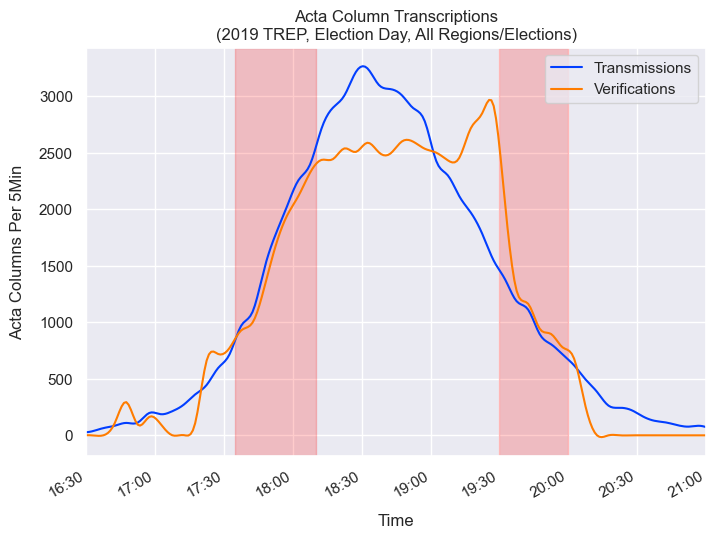

In [16]:
(
    (
        transcript_rates
            .rename(columns={
                'MobileUser': 'Transmissions',
                'SereciVerifier': 'Verifications'
            })
            .shift_index(half_freq) # Move to mid-bin.
            .interp1d_dt()
    )
    .plot(
        title='Acta Column Transcriptions\n(2019 TREP, Election Day, All Regions/Elections)',
        xlabel='Time',
        xlim=pd.to_datetime(['2019-10-20 16:30', '2019-10-20 21:00']),
        x_compat=True,
        ylabel=f'Acta Columns Per {freq}'
    )
    .xaxis.formatter(hhmm_format)
    .hi_traffic_spans()
    .legend(loc='upper right')
)

if save_graphs:
    plt.savefig(path_join('out', '01-tx-verif.png'), dpi=save_dpi)

### Graph #2 ###

In [17]:
sereci_rates = (
    trep[trep.UserType == 'SereciVerifier']
        .resample('5min', on='Fecha Registro en Log')
        .pipe(lambda x: pd.DataFrame({
            'Transcriptions': x.size(),
            'NVerifiers': x.VerificadorUser.nunique()
        }))
)

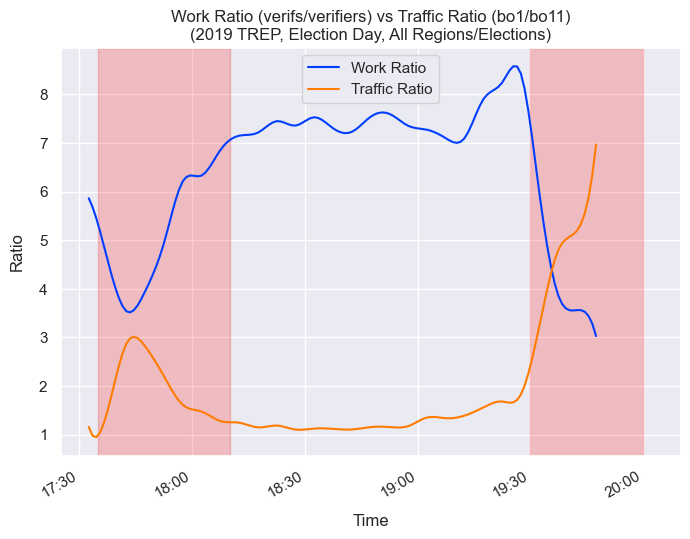

In [18]:
"""
    I don't use EHC's traffic data after 19:45, since it's inaccurate.
    I explain later in 'EHC's Traffic Data is Incomplete'.
"""
(
    (
        sereci_rates[:'2019-10-20 19:45']
            .join(traffic_rates, how='inner')
            .pipe(lambda x: pd.DataFrame({
                'Work Ratio': x.Transcriptions / x.NVerifiers,
                'Traffic Ratio': x.ehc_bo1 / x.ehc_bo11
            }))
            .shift_index(half_freq) # Move to mid-bin.
            .interp1d_dt()
    )
    .plot(
        title='Work Ratio (verifs/verifiers) vs Traffic Ratio (bo1/bo11)\n(2019 TREP, Election Day, All Regions/Elections)',
        xlabel='Time',
        xlim=pd.to_datetime(['2019-10-20 17:25', '2019-10-20 20:10']),
        x_compat=True,
        ylabel='Ratio'
    )
    .xaxis.formatter(hhmm_format)
    .hi_traffic_spans()
)

if save_graphs:
    plt.savefig(path_join('out', '02-work-traffic.png'), dpi=save_dpi)

### Graph #3 ###

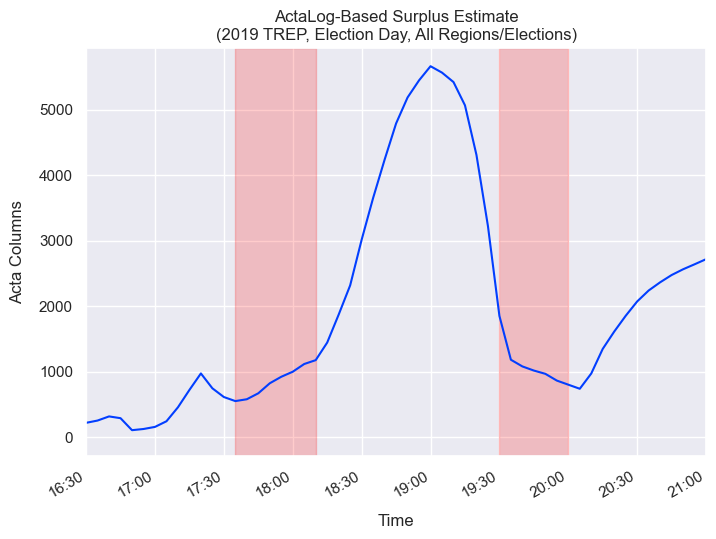

In [19]:
(
    (
        trep
            .drop_duplicates(subset=['NumMesa', 'ElecActa', 'UserType'], keep='first')
            .groupby(['Fecha Registro en Log', 'UserType'])
            .size()
            .unstack('UserType', fill_value=0)
            .pipe(lambda x: x.MobileUser.cumsum() - x.SereciVerifier.cumsum())
            .resample(freq)
            .ffill()
            .fillna(0)
    )
    .plot(
        title='ActaLog-Based Surplus Estimate\n(2019 TREP, Election Day, All Regions/Elections)',
        xlabel='Time',
        xlim=pd.to_datetime(['2019-10-20 16:30', '2019-10-20 21:00']),
        x_compat=True,
        ylabel='Acta Columns'
    )
    .xaxis.formatter(hhmm_format)
    .hi_traffic_spans()
)

if save_graphs:
    plt.savefig(path_join('out', '03-surplus-actalog.png'), dpi=save_dpi)

## Related Analysis ##

### How Did Bolivia's 2019 TREP Count Tally Sheets? ###

A detailed explanation of how the TREP decided which tally sheets to send SERECI users.

Available <a href="https://nbviewer.org/github/distantcomment/bolivia2019/blob/main/how-trep-counted-tally-sheets.ipynb">here</a>.

(SERECI users received sheets with rock-bottom PriorityScores over and over in the suspected shortage periods, which shows there was no surplus.)

### Detailed Surplus Estimate ###

A hyper-specific, impenetrable effort to muscle a surplus estimate from flawed, incomplete data.

Available <a href="https://nbviewer.org/github/distantcomment/bolivia2019/blob/main/detailed-surplus-estimate.ipynb">here</a>.

## Additional Analysis ##

### Excess VerificaProxima Requests ###

When there's a surplus, VerificaProxima clicks and SERECI Verifier transcriptions should be about equal, since the user clicks 'Verifica próxima' once, then transcribes the acta column they receive. However, during shortages, the user clicks multiple times to get an acta column, so there will be 'excess' VerificaProxima requests.

So, I'll calculate:

<code>ExcessRequests = VerificaProximaClicks - SereciVerifierTranscriptions</code>

It should be around zero in non-shortage periods, but > 0 in shortage periods.

In [20]:
traffic_rates.rename(
    columns={'bisite_bo1_verif': 'VerificaProxima'},
    inplace=True
)

<Axes: title={'center': 'Excess VerificaProxima Requests/Clicks\n(2019 TREP, Election Day)'}, xlabel='Time', ylabel='Excess Per 5Min'>

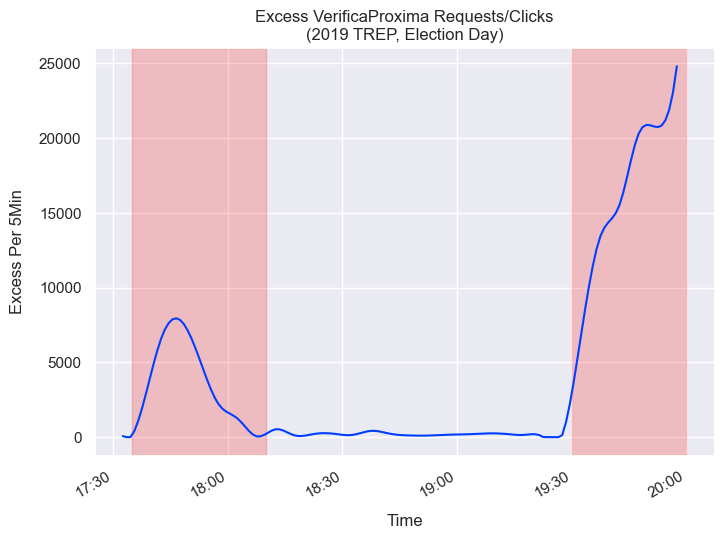

In [21]:
(
    (
        (traffic_rates.VerificaProxima - transcript_rates.SereciVerifier)
            .dropna()
            .to_frame()
            .shift_index(half_freq) # Move to mid-bin.
            .interp1d_dt() # Warning: Creates interpolations below 0. (Lowest real value was 7.)
            .clip(lower=0) # I'll just clip the interplations to 0.
            .squeeze()
    )
    .plot(
        title='Excess VerificaProxima Requests/Clicks\n(2019 TREP, Election Day)',
        xlabel='Time',
        x_compat=True,
        ylabel=f'Excess Per {freq}'
    )
    .xaxis.formatter(hhmm_format)
    .hi_traffic_spans()
)

### High-Traffic Period #2 Started at 19:32 ###

The rate of SERECI Verifier transcriptions crashes at 19:32 and the focus shifts to much newer acta columns.

In [22]:
(
    trep[
        (trep.UserType == 'SereciVerifier')
        & trep.VerificadorDate.between('2019-10-20 19:25', '2019-10-20 19:40', inclusive='left')
    ]
        .assign(TimeBetweenTranscripts=lambda x: x.VerificadorDate - x.PriTransmisionDate)
        .groupby(pd.Grouper(freq='1Min', key='VerificadorDate'))
        .pipe(lambda x: pd.DataFrame({
            'Count': x.size(),
            **{f'{int(p*100)}%': x.TimeBetweenTranscripts.quantile(p).round('s') for p in [0.1, 0.25, 0.5, 0.75, 0.9]}
        }))
        .style.apply(lambda x: np.where(x.index >= '2019-10-20 19:32:00', 'background-color:yellow', ''))
)

,Count,10%,25%,50%,75%,90%
VerificadorDate,,,,,,
2019-10-20 19:25:00,603,0 days 00:00:28,0 days 00:00:49,0 days 00:03:37,0 days 00:23:07,0 days 00:47:58
2019-10-20 19:26:00,578,0 days 00:00:30,0 days 00:00:55,0 days 00:04:10,0 days 00:36:16,0 days 00:57:32
2019-10-20 19:27:00,567,0 days 00:00:28,0 days 00:00:56,0 days 00:04:25,0 days 00:31:55,0 days 00:56:05
2019-10-20 19:28:00,583,0 days 00:00:32,0 days 00:01:02,0 days 00:10:48,0 days 00:51:45,0 days 01:08:06
2019-10-20 19:29:00,585,0 days 00:00:32,0 days 00:01:12,0 days 00:19:38,0 days 00:59:20,0 days 01:11:05
2019-10-20 19:30:00,559,0 days 00:00:29,0 days 00:00:57,0 days 00:06:10,0 days 00:49:15,0 days 01:08:13
2019-10-20 19:31:00,591,0 days 00:00:37,0 days 00:01:12,0 days 00:12:33,0 days 00:51:44,0 days 01:08:03
2019-10-20 19:32:00,337,0 days 00:00:28,0 days 00:00:43,0 days 00:01:13,0 days 00:04:54,0 days 00:50:05
2019-10-20 19:33:00,269,0 days 00:00:27,0 days 00:00:46,0 days 00:01:21,0 days 00:03:23,0 days 00:07:43


### The SERECI's Backup Line Activated Nine Minutes Before Their Internet Was Cut ###

A list of the contiguous periods of IP address usage by SERECI Verifiers:

In [23]:
(
    trep[trep.UserType == 'SereciVerifier']
        .pipe(lambda x: x.groupby((x.VerificadorIP != x.VerificadorIP.shift()).cumsum()))
        .pipe(lambda x: pd.DataFrame({
            'StartTime': x['Fecha Registro en Log'].min(),
            'EndTime': x['Fecha Registro en Log'].max(),
            'Duration': x['Fecha Registro en Log'].max() - x['Fecha Registro en Log'].min(),
            'IP': x.VerificadorIP.first(),
            'VerifAttempts': x.size()
        }))
        .rename_axis(index='Period')
        .style.apply(lambda x: np.where(x.IP == '200.75.161.30', ['background-color:yellow'] * len(x), [''] * len(x)), axis=1)
)

,StartTime,EndTime,Duration,IP,VerifAttempts
Period,,,,,
1,2019-10-20 05:21:28,2019-10-20 08:30:15,0 days 03:08:47,186.121.243.162,4
2,2019-10-20 10:00:35,2019-10-20 12:25:35,0 days 02:25:00,190.129.76.2,42
3,2019-10-20 12:35:17,2019-10-20 19:58:07,0 days 07:22:50,186.121.243.162,62759
4,2019-10-20 19:58:12,2019-10-20 20:06:41,0 days 00:08:29,200.75.161.30,1176
5,2019-10-20 20:06:44,2019-10-20 20:07:00,0 days 00:00:16,186.121.243.162,33
6,2019-10-21 10:37:12,2019-10-21 12:29:08,0 days 01:51:56,190.129.76.2,96
7,2019-10-21 14:38:57,2019-10-21 15:13:28,0 days 00:34:31,18.220.48.51,3213


Based on <i>whois</i> lookups, 186.121.243.162 belonged to AXS Bolivia and 200.75.161.30 belonged to MegaLink. Per an internal TSE <a href="./data/imgs/internal-tse-memo.jpg">document</a> and the <a href="https://www.oas.org/es/sap/deco/informe-bolivia-2019/0.1%20Informe%20Final%20-%20Analisis%20de%20Integridad%20Electoral%20Bolivia%202019%20(OSG).pdf">OAS report</a> (p16), AXS Bolivia was the provider of the SERECI's primary internet line and MegaLink was the provider of the backup line. Therefore, at 19:58:12 their backup line kicked in.

Finally, it's worth note that 18.220.48.51, the source of most verifications on October 21st, is the public IP address of the bo20 server, not a provider of internet service to the SERECI. I thought an anti-MAS researcher would've made a fuss about this, but none ever did. Maybe it was set up as a *forward* proxy? Who knows.

### EHC's Traffic Data is Incomplete ###

EHC's software choked during the second high-traffic period on Election Night.

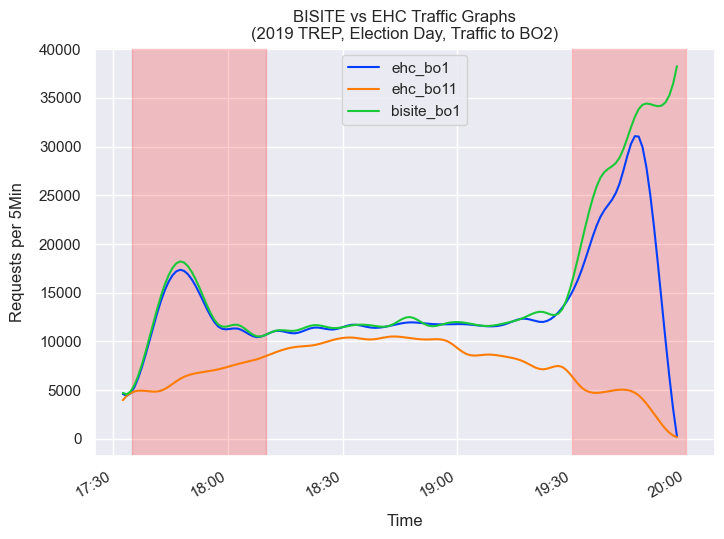

In [24]:
(
    (
        traffic_rates
            .drop(columns='VerificaProxima')
            .dropna()
            .shift_index(half_freq)
            .interp1d_dt()
    )
    .plot(
        title='BISITE vs EHC Traffic Graphs\n(2019 TREP, Election Day, Traffic to BO2)',
        xlabel='Time',
        x_compat=True,
        ylabel=f'Requests per {freq}'
    )
    .xaxis.formatter(hhmm_format)
    .hi_traffic_spans()
    .legend(loc='upper center')
)

So I flat-out ignore their traffic data past 19:45.

### Mapping HTTP Requests to Buttons on the Web Interface ###

In EHC's private report, there's a short log fragment with a list of HTTP requests from the second high-traffic period:

<img src="./data/imgs/ehc-log-fragment.jpg">

Most of the requests can be mapped to specific buttons on the SERECI Verifier web interface:

| Endpoint | Trigger |
| --- | --- |
| VerificaActa/VerificaProxima | SERECI Verifier clicked the 'Verifica Próxima' button to ask for an acta column to transcribe. |
| VerificaActa/editOnView/InvierteImagen/xxxxxxx | SERECI Verifier clicked the 'Invert Image' button to rotate an acta photo. |
| VerificaActa/editOnView/saveAndList/xxxxxxx | SERECI Verifier clicked the '✓' button to submit a transcription. |
| VerificaActa/editOnView/saveAndListConDif/xxxxxxx | SERECI Verifier clicked the '✓ con diferencias' button to submit a transcription *with differences*. |